In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline

**Загрузка датасета Labeled Faces in the Wild Home**

В датасете 13233 изображения размера 250 x 250:

In [3]:
tfds.disable_progress_bar()
lfw_ds = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=False,
    split='train')

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteUZNOYC/lfw-train.tfrecord
Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


**Задание пайплайна данных, параметров обучения, оптимизатора и функции потерь:**

In [0]:
INPUT_DIM = 100
NUM_EPOCHS = 8
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

def prepare(_, img):
    # Нормируем от -1 до 1 - т.к. tanh?
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5
    return img

lfw_ds = lfw_ds.map(prepare)
lfw_ds = lfw_ds.shuffle(buffer_size=13233)
lfw_ds = lfw_ds.repeat(NUM_EPOCHS)
lfw_ds = lfw_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Deep Convolutional Generative Adversarial Network (DCGAN)

Модеь-генератор создаёт изображение (250 x 250), модель-дискриминатор, сравнивая его с реальным изображением, решает задачу бинарной классификации - настоящее (1) ли изображение или сгенерированное (0). В процессе обучения обе модели соревнуются [[link](https://youtu.be/jIP6YZUsj-o)].

In [0]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*5*5, activation='relu'),
    tf.keras.layers.Reshape((5, 5, 256)), # 5 x 5
    tf.keras.layers.UpSampling2D((5, 5)), # 25 x 25   
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((5, 5)), # 125 x 125    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),  
    tf.keras.layers.UpSampling2D((2, 2)), # 250 x 250    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),        
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1), # ответ - настоящее (1) ли изображение или сгенерированное (0)?
])

Проверка размерности сгенерированных изображений:

In [6]:
noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
syntetic_images.shape

(16, 250, 250, 3)

Функция отрисовки изображений:

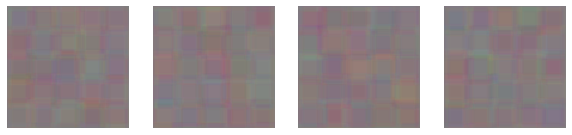

In [7]:
def plot_faces(samples):
    samples = samples / 2. + 0.5
    fig = plt.figure(figsize=(10, 10))
    for j in range(samples.shape[0]):
        ax = fig.add_subplot(1, 4, j+1)
        ax.imshow(samples[j, ...], cmap='gray')
        ax.axis('off')
    plt.show()

plot_faces(syntetic_images[:4, ...])

## Обучение генератора и дискриминатора


[Step  0] D Loss: 0.7068; G Loss: 0.7540 (18 sec)


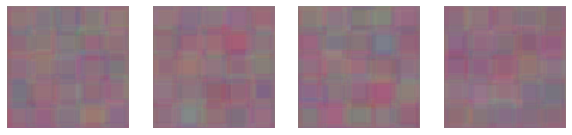

100 200 300 400 
[Step 500] D Loss: 0.0000; G Loss: 4.8380 (947 sec)


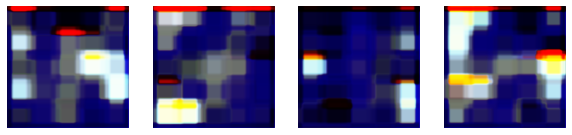

600 700 800 900 
[Step 1000] D Loss: 1.1470; G Loss: 10.0198 (1875 sec)


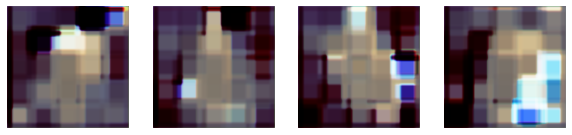

1100 1200 1300 1400 
[Step 1500] D Loss: 0.1534; G Loss: 101.1135 (2802 sec)


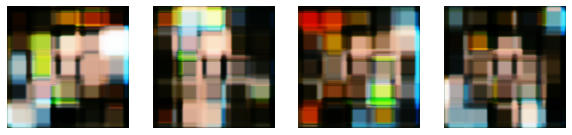

1600 1700 1800 1900 
[Step 2000] D Loss: 0.1883; G Loss: 23.5895 (3734 sec)


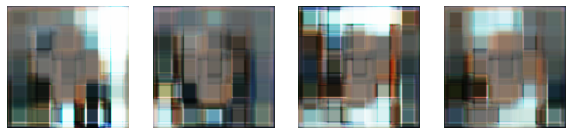

2100 2200 2300 2400 
[Step 2500] D Loss: 0.2209; G Loss: 57.8070 (4664 sec)


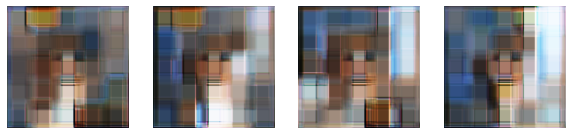

2600 2700 2800 2900 
[Step 3000] D Loss: 0.0000; G Loss: 41.7490 (5592 sec)


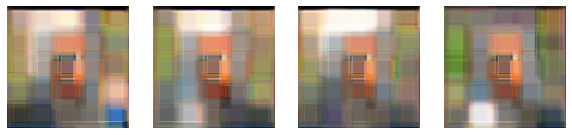

3100 3200 3300 3400 
[Step 3500] D Loss: 0.0000; G Loss: 104.4253 (6521 sec)


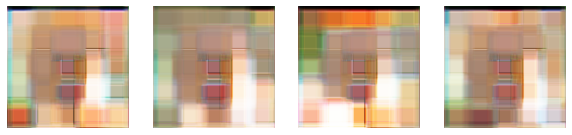

3600 3700 3800 3900 
[Step 4000] D Loss: 0.0000; G Loss: 73.4664 (7448 sec)


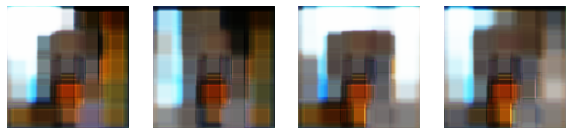

4100 4200 4300 4400 
[Step 4500] D Loss: 0.0000; G Loss: 214.0361 (8378 sec)


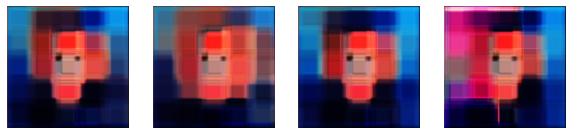

4600 4700 4800 4900 
[Step 5000] D Loss: 0.0000; G Loss: 124.0384 (9307 sec)


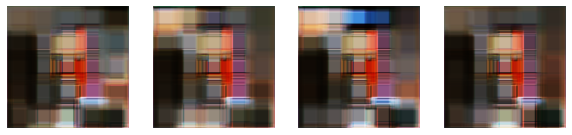

5100 5200 5300 5400 
[Step 5500] D Loss: 0.0000; G Loss: 213.0817 (10233 sec)


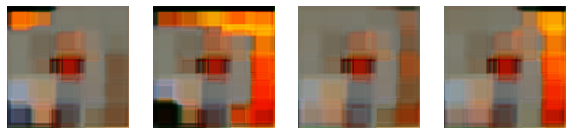

5600 5700 5800 5900 
[Step 6000] D Loss: 0.0000; G Loss: 179.1983 (11159 sec)


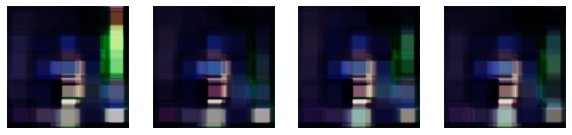

6100 6200 6300 6400 
[Step 6500] D Loss: 0.0000; G Loss: 181.7831 (12085 sec)


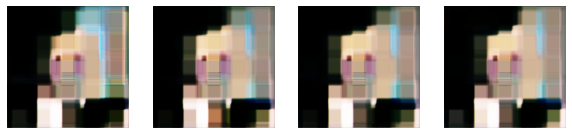

6600 CPU times: user 36min 22s, sys: 14min 38s, total: 51min
Wall time: 3h 24min 57s


In [8]:
%%time

start_time = time.time()

for step, true_images in enumerate(lfw_ds):

    # Train Discriminator

    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images,
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32),
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))

    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    # Train Generator

    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)

    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    # Check intermediate results

    if step % 500 == 0:
        print('\n[Step %2d] D Loss: %.4f; G Loss: %.4f (%.0f sec)' % (
            step, d_loss_value.numpy(), g_loss_value.numpy(), time.time()-start_time))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_faces(syntetic_images[:4, ...])
    elif step % 100 == 0:
        print(step, end=' ')        

**Тестирование свёрточного генератора**

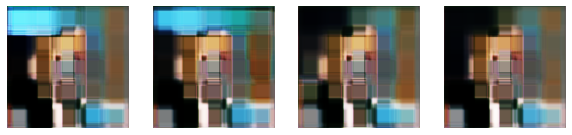

In [9]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images[:4, ...])

**Интерполяция в латентном пространстве**

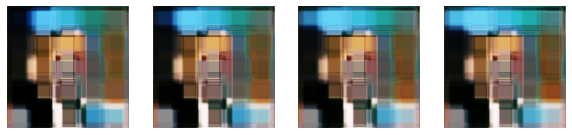

In [10]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images[:4, ...])

Модели обучаются достаточно долго, но уже сейчас можно увидеть, что на сгенерированном изображении проявляется что-то отдалённо похожее на схематическое человеческое лицо. Стоит отметить, что в отличие от датасета MNIST (с чёрно-белыми цифрами размера 28 x 28) реальные изображения здесь цветные, на порядок больше размером и куда более вариативны в плане представления объектов.

## Сохранение моделей

Всегда можно вернуться к их дообучению.

In [0]:
generator.save('/content/drive/My Drive/dcgan_generator.h5')
discriminator.save('/content/drive/My Drive/dcgan_discriminator.h5')